### Imports

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import numpy as np

In [12]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 3060')

### Hyperparameters

In [13]:
batch_size = 16
learning_rate = 1e-4
num_epochs = 75
save_interval = 5
num_classes = 4
dir = 'aug-hp-vit-base'
import wandb

sweep_config = {
    'method': 'grid', 
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'batch_size': {'values': [16, 32]},
        'learning_rate': {'values': [1e-5, 1e-4, 5e-4]}, 
        'num_epochs': {'value': num_epochs},  
        'num_classes': {'value': num_classes}, 
    }
}

In [14]:
sweep_id = wandb.sweep(sweep_config, project="aug-vit-bc-hp-base-patch16-224")

Create sweep with ID: fp7rmnw0
Sweep URL: https://wandb.ai/adam-kacmar59-fiit-stu/aug-vit-bc-hp-base-patch16-224/sweeps/fp7rmnw0


### Data Preprocessing

In [15]:
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),  # Rotate up to ±15 degrees
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Small affine transformation
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply random perspective distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

### Load Datasets


In [16]:
full_train_dataset = datasets.ImageFolder("augmented-dataset/train")

train_size = int(0.875 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

train_indices = train_subset.indices
val_indices = val_subset.indices


train_dataset_full = datasets.ImageFolder("augmented-dataset/train", transform=transform)
val_dataset_full = datasets.ImageFolder("augmented-dataset/train", transform=transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

test_dataset = datasets.ImageFolder("augmented-dataset/test", transform=transform)

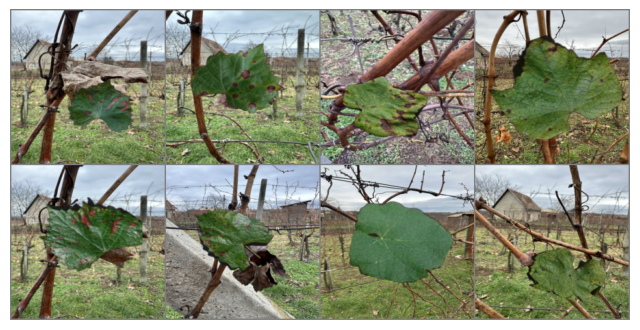

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

# Unnormalize and make a grid
grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean  # unnormalize
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

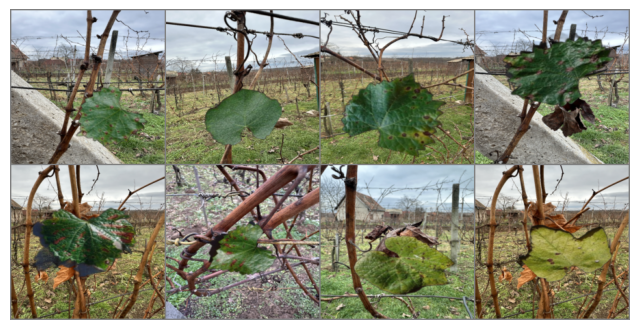

In [18]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

# Unnormalize and make a grid
grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean  # unnormalize
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

### Training Function


In [19]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

### Validation Function


In [20]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy

### Main Function


In [21]:
import os

os.makedirs(dir, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
def train_with_sweep():
    # Initialize W&B
    wandb.init()

    # Get hyperparameters from W&B
    config = wandb.config

    # Set up model
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224", 
        num_labels=config.num_classes, 
        ignore_mismatched_sizes=True)
    model.to(device)    

    # Set up optimizer and criterion
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config.learning_rate
        )
    criterion = nn.CrossEntropyLoss()

    # Dynamically set batch size in DataLoader
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    patience = 10  # Stop training if no improvement for 'patience' epochs
    min_delta = 1e-4  # Minimum change in val_loss to qualify as improvement
    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(config.num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")

        # Validation
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Log metrics to W&B
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'epoch': epoch + 1
        })

        # Check early stopping criteria
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            # Save the model if it's the best so far
            torch.save(model.state_dict(), f'{dir}/model_lr{config.learning_rate}_bs{config.batch_size}.pth')
            print(f"New best model saved. Validation Loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        # Early stopping condition
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("Evaluating the best model on the test dataset...")
    model.load_state_dict(torch.load(f'{dir}/model_lr{config.learning_rate}_bs{config.batch_size}.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    # Log final test accuracy to W&B
    wandb.log({'final_test_accuracy': test_accuracy})

wandb.agent(sweep_id, function=train_with_sweep)

wandb: Agent Starting Run: 4df1txsb with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	num_classes: 4
wandb: 	num_epochs: 75
wandb: Currently logged in as: adam-kacmar59 (adam-kacmar59-fiit-stu). Use `wandb login --relogin` to force relogin


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.1589
Validation Loss: 0.0466, Validation Accuracy: 0.9856
New best model saved. Validation Loss: 0.0466
Epoch 2/75
Train Loss: 0.0173
Validation Loss: 0.0230, Validation Accuracy: 0.9934
New best model saved. Validation Loss: 0.0230
Epoch 3/75
Train Loss: 0.0072
Validation Loss: 0.0274, Validation Accuracy: 0.9922
No improvement in validation loss for 1 epoch(s).
Epoch 4/75
Train Loss: 0.0059
Validation Loss: 0.0269, Validation Accuracy: 0.9911
No improvement in validation loss for 2 epoch(s).
Epoch 5/75
Train Loss: 0.0029
Validation Loss: 0.0355, Validation Accuracy: 0.9895
No improvement in validation loss for 3 epoch(s).
Epoch 6/75
Train Loss: 0.0066
Validation Loss: 0.0291, Validation Accuracy: 0.9906
No improvement in validation loss for 4 epoch(s).
Epoch 7/75
Train Loss: 0.0007
Validation Loss: 0.0250, Validation Accuracy: 0.9939
No improvement in validation loss for 5 epoch(s).
Epoch 8/75
Train Loss: 0.0002
Validation Loss: 0.0272, Validation Accuracy: 0

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\897341745.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{dir}/model_lr{config.lear

Final Test Accuracy: 0.9925


epoch,▁▂▂▃▄▄▅▅▆▇▇█
final_test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▆▅▄▅▇▇█▇▇▆
val_loss,█▁▂▂▅▃▂▂▂▂▃▄
epoch,12
final_test_accuracy,0.99252
train_loss,0.00085
val_accuracy,0.9928
val_loss,0.03389


wandb: Agent Starting Run: r9df85qv with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	num_classes: 4
wandb: 	num_epochs: 75


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.1054
Validation Loss: 0.1238, Validation Accuracy: 0.9612
New best model saved. Validation Loss: 0.1238
Epoch 2/75
Train Loss: 0.0362
Validation Loss: 0.1802, Validation Accuracy: 0.9424
No improvement in validation loss for 1 epoch(s).
Epoch 3/75
Train Loss: 0.0283
Validation Loss: 0.0232, Validation Accuracy: 0.9922
New best model saved. Validation Loss: 0.0232
Epoch 4/75
Train Loss: 0.0244
Validation Loss: 0.0326, Validation Accuracy: 0.9922
No improvement in validation loss for 1 epoch(s).
Epoch 5/75
Train Loss: 0.0201
Validation Loss: 0.0651, Validation Accuracy: 0.9790
No improvement in validation loss for 2 epoch(s).
Epoch 6/75
Train Loss: 0.0253
Validation Loss: 0.1218, Validation Accuracy: 0.9585
No improvement in validation loss for 3 epoch(s).
Epoch 7/75
Train Loss: 0.0147
Validation Loss: 0.1152, Validation Accuracy: 0.9601
No improvement in validation loss for 4 epoch(s).
Epoch 8/75
Train Loss: 0.0238
Validation Loss: 0.0681, Validation Accuracy: 0

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\897341745.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{dir}/model_lr{config.lear

Final Test Accuracy: 0.9922


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
final_test_accuracy,▁
train_loss,█▃▂▂▂▂▁▂▁▁▁▂▂
val_accuracy,▄▁██▆▃▃▆▆▇▂▄▇
val_loss,▅█▁▁▃▅▅▃▃▂█▅▁
epoch,13
final_test_accuracy,0.99224
train_loss,0.01987
val_accuracy,0.98671
val_loss,0.0335


wandb: Agent Starting Run: vwf4n124 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0005
wandb: 	num_classes: 4
wandb: 	num_epochs: 75


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.4535
Validation Loss: 0.2304, Validation Accuracy: 0.9075
New best model saved. Validation Loss: 0.2304
Epoch 2/75
Train Loss: 0.2068
Validation Loss: 0.2226, Validation Accuracy: 0.9158
New best model saved. Validation Loss: 0.2226
Epoch 3/75
Train Loss: 0.1607
Validation Loss: 0.2188, Validation Accuracy: 0.9258
New best model saved. Validation Loss: 0.2188
Epoch 4/75
Train Loss: 0.1349
Validation Loss: 0.1489, Validation Accuracy: 0.9419
New best model saved. Validation Loss: 0.1489
Epoch 5/75
Train Loss: 0.1142
Validation Loss: 0.2112, Validation Accuracy: 0.9252
No improvement in validation loss for 1 epoch(s).
Epoch 6/75
Train Loss: 0.1105
Validation Loss: 0.1816, Validation Accuracy: 0.9308
No improvement in validation loss for 2 epoch(s).
Epoch 7/75
Train Loss: 0.0983
Validation Loss: 0.1395, Validation Accuracy: 0.9513
New best model saved. Validation Loss: 0.1395
Epoch 8/75
Train Loss: 0.1039
Validation Loss: 0.1549, Validation Accuracy: 0.9491
No imp

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\897341745.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{dir}/model_lr{config.lear

Final Test Accuracy: 0.9452


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
final_test_accuracy,▁
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▇▄▅██▆▆▅▄▆█▆▇▁
val_loss,▅▅▄▁▄▃▁▂▂▄▄▆▂▁▃▂█
epoch,17
final_test_accuracy,0.94515
train_loss,0.05085
val_accuracy,0.90587
val_loss,0.30224


wandb: Agent Starting Run: zjr62eim with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	num_classes: 4
wandb: 	num_epochs: 75


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.2351
Validation Loss: 0.0448, Validation Accuracy: 0.9850
New best model saved. Validation Loss: 0.0448
Epoch 2/75
Train Loss: 0.0214
Validation Loss: 0.0357, Validation Accuracy: 0.9873
New best model saved. Validation Loss: 0.0357
Epoch 3/75
Train Loss: 0.0048
Validation Loss: 0.0294, Validation Accuracy: 0.9917
New best model saved. Validation Loss: 0.0294
Epoch 4/75
Train Loss: 0.0024
Validation Loss: 0.0225, Validation Accuracy: 0.9934
New best model saved. Validation Loss: 0.0225
Epoch 5/75
Train Loss: 0.0010
Validation Loss: 0.0219, Validation Accuracy: 0.9939
New best model saved. Validation Loss: 0.0219
Epoch 6/75
Train Loss: 0.0006
Validation Loss: 0.0256, Validation Accuracy: 0.9922
No improvement in validation loss for 1 epoch(s).
Epoch 7/75
Train Loss: 0.0006
Validation Loss: 0.0238, Validation Accuracy: 0.9945
No improvement in validation loss for 2 epoch(s).
Epoch 8/75
Train Loss: 0.0003
Validation Loss: 0.0244, Validation Accuracy: 0.9934
No imp

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\897341745.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{dir}/model_lr{config.lear

Final Test Accuracy: 0.9928


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇█▆█▇▇▇▇▇▇█▇
val_loss,█▅▃▁▁▂▂▂▂▂▂▃▃▃▃
epoch,15
final_test_accuracy,0.9928
train_loss,4e-05
val_accuracy,0.99336
val_loss,0.02954


wandb: Agent Starting Run: 5d7qnk9a with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_classes: 4
wandb: 	num_epochs: 75


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.1091
Validation Loss: 0.0544, Validation Accuracy: 0.9806
New best model saved. Validation Loss: 0.0544
Epoch 2/75
Train Loss: 0.0270
Validation Loss: 0.0376, Validation Accuracy: 0.9850
New best model saved. Validation Loss: 0.0376
Epoch 3/75
Train Loss: 0.0185
Validation Loss: 0.0229, Validation Accuracy: 0.9922
New best model saved. Validation Loss: 0.0229
Epoch 4/75
Train Loss: 0.0148
Validation Loss: 0.0493, Validation Accuracy: 0.9806
No improvement in validation loss for 1 epoch(s).
Epoch 5/75
Train Loss: 0.0212
Validation Loss: 0.0300, Validation Accuracy: 0.9862
No improvement in validation loss for 2 epoch(s).
Epoch 6/75
Train Loss: 0.0144
Validation Loss: 0.0351, Validation Accuracy: 0.9845
No improvement in validation loss for 3 epoch(s).
Epoch 7/75
Train Loss: 0.0227
Validation Loss: 0.0431, Validation Accuracy: 0.9839
No improvement in validation loss for 4 epoch(s).
Epoch 8/75
Train Loss: 0.0115
Validation Loss: 0.0231, Validation Accuracy: 0.992

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\897341745.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{dir}/model_lr{config.lear

Final Test Accuracy: 0.9889


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
final_test_accuracy,▁
train_loss,█▂▂▂▂▂▂▁▁▁▂▁▁
val_accuracy,▁▄█▁▄▃▃█▃▂▆▆▅
val_loss,█▄▁▇▃▄▅▁▇█▅▃▆
epoch,13
final_test_accuracy,0.98892
train_loss,0.00598
val_accuracy,0.98726
val_loss,0.04552


wandb: Agent Starting Run: bpcpt22u with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005
wandb: 	num_classes: 4
wandb: 	num_epochs: 75


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/75
Train Loss: 0.2962
Validation Loss: 0.2849, Validation Accuracy: 0.8749
New best model saved. Validation Loss: 0.2849
Epoch 2/75
Train Loss: 0.1319
Validation Loss: 0.1763, Validation Accuracy: 0.9363
New best model saved. Validation Loss: 0.1763
Epoch 3/75
Train Loss: 0.1156
Validation Loss: 0.1163, Validation Accuracy: 0.9601
New best model saved. Validation Loss: 0.1163
Epoch 4/75
Train Loss: 0.0968
Validation Loss: 0.1262, Validation Accuracy: 0.9574
No improvement in validation loss for 1 epoch(s).
Epoch 5/75
Train Loss: 0.0818
Validation Loss: 0.1340, Validation Accuracy: 0.9563
No improvement in validation loss for 2 epoch(s).
Epoch 6/75
Train Loss: 0.0681
Validation Loss: 0.2057, Validation Accuracy: 0.9347
No improvement in validation loss for 3 epoch(s).
Epoch 7/75
Train Loss: 0.0715
Validation Loss: 0.1621, Validation Accuracy: 0.9408
No improvement in validation loss for 4 epoch(s).
Epoch 8/75
Train Loss: 0.0541
Validation Loss: 0.0960, Validation Accuracy: 0.964

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\897341745.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{dir}/model_lr{config.lear

Final Test Accuracy: 0.9668


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
final_test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇▅▆▇▆▇▅▆▆▇▇█▇▇
val_loss,█▄▂▂▂▅▃▁▃▂▄▅▄▃▂▁▃▂
epoch,18
final_test_accuracy,0.96676
train_loss,0.03956
val_accuracy,0.96124
val_loss,0.12499


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [22]:
import itertools

# Define the directory where models are stored
output_dir = dir

class_names = ["Healthy", "Black Rot", "Leaf Blight", "ESCA"]

# Extract hyperparameter values correctly
batch_sizes = sweep_config['parameters']['batch_size']['values']
learning_rates = sweep_config['parameters']['learning_rate']['values']
num_classes = sweep_config['parameters']['num_classes']['value']  # Correct access

# Generate all combinations of batch_size and learning_rate
hyperparameter_combinations = list(itertools.product(batch_sizes, learning_rates))

# Store results
results = []

# Iterate through each hyperparameter combination
for batch_size, learning_rate in hyperparameter_combinations:  # Unpack combo correctly
    model_path = f"{output_dir}/model_lr{learning_rate}_bs{batch_size}.pth"

    try:
        # Load model
        model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224", 
            num_labels=config.num_classes, 
            ignore_mismatched_sizes=True
        )
        model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()

        # Create test DataLoader with current batch_size
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Evaluate model
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
                outputs = model(images).logits
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Model: LR={learning_rate}, Batch={batch_size} → Test Accuracy: {test_accuracy:.4f}")

        # Store result
        results.append({
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "test_accuracy": test_accuracy
        })

        cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
        disp.plot(ax=ax_cm, cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title(f"Confusion Matrix\nLR={learning_rate}, BS={batch_size}")
        plt.tight_layout()
        os.makedirs("augvit_confusion_matrices", exist_ok=True)
        plt.savefig(f"augvit_confusion_matrices/cm_lr{learning_rate}_bs{batch_size}.png")
        plt.close()

    except Exception as e:
        print(f"Error loading model_lr{learning_rate}_bs{batch_size}.pth: {e}")

# Sort results by accuracy for easy comparison
results.sort(key=lambda x: x["test_accuracy"], reverse=True)

# Print final results
print("\nFinal Evaluation Results:")
for res in results:
    print(f"LR={res['learning_rate']}, Batch={res['batch_size']} → Test Accuracy: {res['test_accuracy']:.4f}")


Error loading model_lr1e-05_bs16.pth: name 'config' is not defined
Error loading model_lr0.0001_bs16.pth: name 'config' is not defined
Error loading model_lr0.0005_bs16.pth: name 'config' is not defined
Error loading model_lr1e-05_bs32.pth: name 'config' is not defined
Error loading model_lr0.0001_bs32.pth: name 'config' is not defined
Error loading model_lr0.0005_bs32.pth: name 'config' is not defined

Final Evaluation Results:


In [23]:
import cv2
import numpy as np
import torch

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image

image_path = "dataset/test/Healthy/0c1667a2-61d7-4dee-b4d9-0d141a1ceb20___Mt.N.V_HL 9127_new30degFlipLR.JPG"
device = "cuda" if torch.cuda.is_available() else "cpu"

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


if __name__ == '__main__':
    """ python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.

    """
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224", 
        num_labels=4, 
        ignore_mismatched_sizes=True
    ).to(device)

    # Load the fine-tuned weights from your checkpoint
    model.load_state_dict(torch.load('hp-vit-base/model_lr0.0001_bs16.pth', map_location=device))
    model.eval()

    target_layers = model.vit.layernorm

    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5]).to(device)

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=True,
                        aug_smooth=True)

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(f'grad_cam.jpg', cam_image)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\303035541.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

TypeError: 'LayerNorm' object is not iterable

In [ ]:
for name, module in model.named_modules():
    print(name)


vit
vit.embeddings
vit.embeddings.patch_embeddings
vit.embeddings.patch_embeddings.projection
vit.embeddings.dropout
vit.encoder
vit.encoder.layer
vit.encoder.layer.0
vit.encoder.layer.0.attention
vit.encoder.layer.0.attention.attention
vit.encoder.layer.0.attention.attention.query
vit.encoder.layer.0.attention.attention.key
vit.encoder.layer.0.attention.attention.value
vit.encoder.layer.0.attention.attention.dropout
vit.encoder.layer.0.attention.output
vit.encoder.layer.0.attention.output.dense
vit.encoder.layer.0.attention.output.dropout
vit.encoder.layer.0.intermediate
vit.encoder.layer.0.intermediate.dense
vit.encoder.layer.0.intermediate.intermediate_act_fn
vit.encoder.layer.0.output
vit.encoder.layer.0.output.dense
vit.encoder.layer.0.output.dropout
vit.encoder.layer.0.layernorm_before
vit.encoder.layer.0.layernorm_after
vit.encoder.layer.1
vit.encoder.layer.1.attention
vit.encoder.layer.1.attention.attention
vit.encoder.layer.1.attention.attention.query
vit.encoder.layer.1.atte